In [ ]:
# !pip install qpsolvers==2.6
# from qpsolvers import solve_qp

In [ ]:
# !pip install quadprog

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
import matplotlib

# SVM Hard Margin: Aplicação no Iris dataset

In [2]:
class SVM_hardmargin():

  def __init__(self, solver ="quadprog", tol=1e-5 ):
    self.solver = solver
    self.tol = tol

  def fit(self,X,y):

    # Check https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

    class_labels = np.unique(y)
    assert len(class_labels)==2, "y precisa ser binário"
    assert (isinstance(X,  (np.ndarray, np.generic))) & (isinstance(y, (np.ndarray, np.generic))), "X e y devem ser do tipo pandas DataFrame"

    # X = np.array(X)
    # y = np.array(y)
    self.m = X.shape[0]

    self.X=X
    self.y=y
    
    # Equação principal
    P = np.dot(y*X, (y*X).T)
    q = -np.ones((self.m,1)).reshape(-1,1)

    # Igualdade
    A = y.reshape(1,-1)
    b= 0.0

    # Inegualidades
    G = -np.eye(self.m)
    h = np.zeros(self.m).reshape(-1,1)

    P       = cvxopt.matrix(P)
    q       = cvxopt.matrix(q)
    G       = cvxopt.matrix(G)
    h       = cvxopt.matrix(h)
    A       = cvxopt.matrix(A)
    b       = cvxopt.matrix(b)

    solved  = cvxopt.solvers.qp(P, q, G, h, A, b) ;
    alpha = solved['x']

    alpha = np.array(alpha)
    sv = (alpha>1e-5).flatten()

    w = np.dot((alpha[sv]*y[sv]).reshape(1,-1), X[sv])[0] # w precisar ter dimensao 1 x ne

    # w = np.dot((alpha*y).reshape(1,-1), X)[0] # w precisar ter dimensao 1 x ne
    wx = np.dot(X[sv], w)

    # b = 1/self.m*(np.sum(y[sv] - wx))
    b = np.mean(y[sv] - wx)

    self.w = w
    self.b = b
    self.alpha = alpha
    self.sv = sv


  def predict(self, X_tst):
    wx = np.dot(self.w, X_tst.T)
    yhat = wx + self.b
    yhat = np.sign(yhat)
    return yhat


# w       = np.dot((y * alphas).T, X)[0]
# S       = (alphas > 1e-5).flatten()
# b       = np.mean(y[S] - np.dot(X[S], w.reshape(-1, 1)))

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris["data"], iris["target"]], columns= iris["feature_names"] + ["target"])

# Retain only 2 linearly separable classes
iris_df = iris_df[iris_df["target"].isin([0,1])]
iris_df["target"] = iris_df[["target"]].replace(0,-1)

# Select only 2 attributes
iris_df = iris_df[["petal length (cm)", "petal width (cm)", "target"]]
iris_df.head()

petal length (cm)  petal width (cm)  target
0                1.4               0.2    -1.0
1                1.4               0.2    -1.0
2                1.3               0.2    -1.0
3                1.5               0.2    -1.0
4                1.4               0.2    -1.0

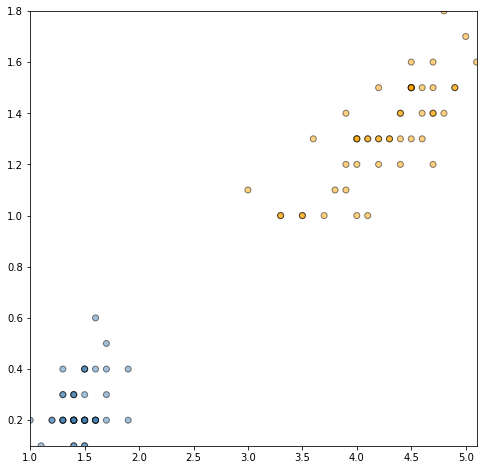

In [4]:
X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = iris_df[["target"]].to_numpy()

plt.figure(figsize=(8, 8))
colors = ["steelblue", "orange"]
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")

x_min = min(X[:, 0])
x_max = max(X[:, 0])

y_min = min(X[:, 1])
y_max = max(X[:, 1])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [5]:
classifier = SVM_hardmargin()
classifier.fit(X,y)
print('w:', classifier.w, 'b:', classifier.b)

     pcost       dcost       gap    pres   dres
 0: -5.8693e+00 -1.1241e+01  3e+02  1e+01  2e+00
 1: -5.9277e+00 -3.6988e+00  4e+01  2e+00  3e-01
 2: -1.0647e+00 -1.9434e+00  5e+00  2e-01  2e-02
 3: -6.5979e-01 -1.1956e+00  6e-01  6e-03  8e-04
 4: -8.3813e-01 -1.2988e+00  5e-01  3e-03  4e-04
 5: -1.1588e+00 -1.1784e+00  2e-02  8e-05  1e-05
 6: -1.1763e+00 -1.1765e+00  2e-04  8e-07  1e-07
 7: -1.1765e+00 -1.1765e+00  2e-06  8e-09  1e-09
 8: -1.1765e+00 -1.1765e+00  2e-08  8e-11  1e-11
Optimal solution found.
w: [1.29411766 0.82352941] b: -3.7882353122348555


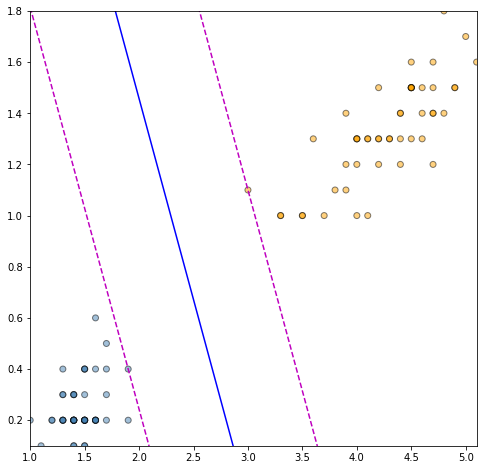

In [6]:
def plot_margin(X,classifier, title=None):

  w = classifier.w
  b = classifier.b

  x_min = min(X[:, 0])
  x_max = max(X[:, 0])

  y_min = min(X[:, 1])
  y_max = max(X[:, 1])

  xx = np.linspace(x_min, x_max)
  a = -w[0]/w[1]
  yy = a*xx - (b)/w[1]
  margin = 1 / np.sqrt(np.sum(w**2))
  yy_neg = yy - np.sqrt(1 + a**2) * margin
  yy_pos = yy + np.sqrt(1 + a**2) * margin
  plt.figure(figsize=(8, 8))
  plt.plot(xx, yy, "b-")
  plt.plot(xx, yy_neg, "m--")
  plt.plot(xx, yy_pos, "m--")
  colors = ["steelblue", "orange"]
  plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  if title is not None:
    plt.title(title)
  plt.show()

plot_margin(X, classifier)

# SVM soft margin + aplicação em duas distribuições aleatórias

In [7]:

class SVM():

  def __init__(self, C, solver ="quadprog", tol=1e-5, verbose=True):
    assert C>0, 'C precisa ser uma constante positiva'
    self.C=float(C)
    self.solver = solver
    self.tol = tol
    self.verbose=verbose
    cvxopt.solvers.options['show_progress'] = verbose

  def fit(self,X,y):

    # Check https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

    class_labels = np.unique(y)
    assert len(class_labels)==2, "y precisa ser binário"
    #assert (isinstance(X,  (np.ndarray, np.generic))) & (isinstance(y, (np.ndarray, np.generic))), "X e y devem ser do tipo pandas DataFrame"

    X = np.array(X)
    y = np.array(y)
    self.m = X.shape[0]

    self.X=X
    self.y=y
    
    # Equação principal
    P = np.dot(y*X, (y*X).T)
    q = -np.ones((self.m,1)).reshape(-1,1)

    # Inegualidades
    G_lb = -np.eye(self.m)
    h_lb = np.zeros(self.m).reshape(-1,1)

    G_ub = np.eye(self.m)
    h_ub = self.C*np.ones(self.m).reshape(-1,1)

    G = np.vstack((G_lb,G_ub))
    h = np.vstack((h_lb,h_ub))

    # Igualdade
    A = y.reshape(1,-1).astype(float)
    b= 0.0

    P       = cvxopt.matrix(P)
    q       = cvxopt.matrix(q)
    G       = cvxopt.matrix(G)
    h       = cvxopt.matrix(h)
    A       = cvxopt.matrix(A)
    b       = cvxopt.matrix(b)

    solved  = cvxopt.solvers.qp(P, q, G, h, A, b) ;
    alpha = solved['x']

    alpha = np.array(alpha)
    sv = (alpha>1e-5).flatten()
    w = np.dot((alpha[sv]*y[sv]).reshape(1,-1), X[sv])[0] # w precisar ter dimensao 1 x ne
    wx = np.dot(X[sv], w)
    b = np.mean(y[sv] - wx)

    self.w = w
    self.b = b
    self.alpha = alpha
    self.sv = sv


  def predict(self, X_tst):
    wx = np.dot(self.w, X_tst.T)
    yhat = wx + self.b
    yhat = np.sign(yhat)
    return yhat

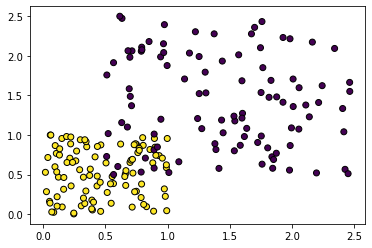

In [8]:
X1 = np.random.random([100,2])*np.array([1,1])
y1 = np.ones(100).reshape(-1,1)

X2 = np.random.random([100,2])*np.array([2,2]) + 0.5
y2 = -np.ones(100).reshape(-1,1)

X = np.vstack((X1,X2))
y  = np.vstack((y1,y2))

plt.scatter(X[:, 0],
            X[:, 1],
            c=y,
            edgecolors="black")

     pcost       dcost       gap    pres   dres
 0: -2.8895e+02 -1.5011e+04  4e+04  8e-01  7e-14
 1: -1.2041e+02 -4.5474e+03  6e+03  7e-02  7e-14
 2: -1.8215e+02 -1.0381e+03  1e+03  9e-03  5e-14
 3: -2.7135e+02 -5.9437e+02  3e+02  3e-03  5e-14
 4: -2.9548e+02 -5.0219e+02  2e+02  1e-03  5e-14
 5: -3.0335e+02 -4.7787e+02  2e+02  8e-04  5e-14
 6: -3.3020e+02 -4.4796e+02  1e+02  4e-04  5e-14
 7: -3.5017e+02 -3.9846e+02  5e+01  1e-04  7e-14
 8: -3.5360e+02 -3.8815e+02  3e+01  5e-05  6e-14
 9: -3.5810e+02 -3.7711e+02  2e+01  1e-05  6e-14
10: -3.6160e+02 -3.7101e+02  9e+00  5e-06  5e-14
11: -3.6531e+02 -3.6598e+02  7e-01  1e-07  7e-14
12: -3.6561e+02 -3.6561e+02  8e-03  2e-09  6e-14
13: -3.6561e+02 -3.6561e+02  8e-05  2e-11  7e-14
Optimal solution found.


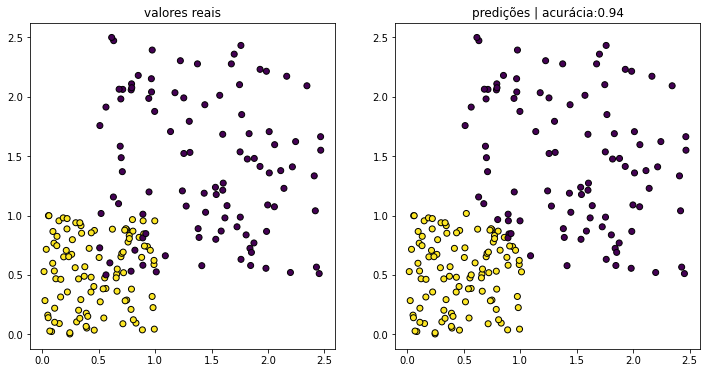

In [9]:
def pipeline_SVM(model):
  classifier = model
  alphas = classifier.fit(X,y)
  ypred = classifier.predict(X)

  fig, axis = plt.subplots(1,2, figsize=(12,6))

  axis[0].scatter(X[:, 0],
                  X[:, 1],
                  c=y,
                  edgecolors="black")
  axis[0].set_title('valores reais')

  axis[1].scatter(X[:, 0],
                  X[:, 1],
                  c=ypred,
                  edgecolors="black")
  axis[1].set_title('predições | acurácia:{}'.format(np.mean(y.flatten()==ypred.flatten())))

C=10
pipeline_SVM(SVM(C=C))

     pcost       dcost       gap    pres   dres
 0: -3.1682e+01 -9.3375e-01  1e+03  4e+01  6e-15
 1: -1.0834e+00 -9.0396e-01  2e+01  6e-01  5e-15
 2: -4.1655e-01 -5.1192e-01  2e+00  7e-02  9e-16
 3: -1.6197e-01 -4.0269e-01  2e-01  1e-17  2e-15
 4: -1.8078e-01 -2.0087e-01  2e-02  8e-18  6e-16
 5: -1.9131e-01 -1.9157e-01  3e-04  3e-18  4e-16
 6: -1.9145e-01 -1.9145e-01  3e-06  5e-17  4e-16
 7: -1.9145e-01 -1.9145e-01  3e-08  3e-17  3e-16
Optimal solution found.


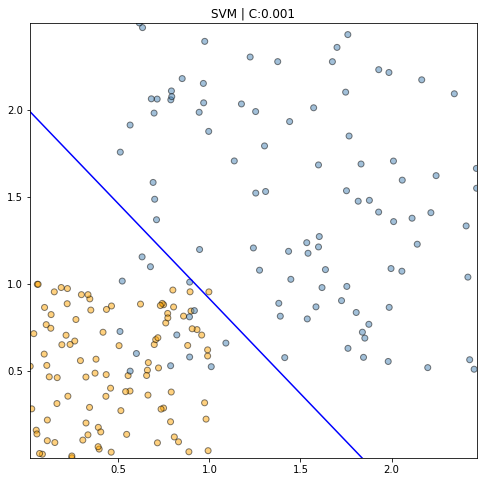

     pcost       dcost       gap    pres   dres
 0: -3.1962e+01 -4.4925e+00  1e+03  4e+01  5e-15
 1: -1.3155e+00 -4.4688e+00  2e+01  3e-01  5e-15
 2: -1.0275e+00 -3.0529e+00  2e+00  1e-16  6e-16
 3: -1.1483e+00 -1.4429e+00  3e-01  1e-16  5e-16
 4: -1.2491e+00 -1.3193e+00  7e-02  1e-16  4e-16
 5: -1.2725e+00 -1.2912e+00  2e-02  2e-16  4e-16
 6: -1.2801e+00 -1.2826e+00  2e-03  1e-16  4e-16
 7: -1.2813e+00 -1.2813e+00  9e-05  9e-17  5e-16
 8: -1.2813e+00 -1.2813e+00  3e-06  4e-17  5e-16
 9: -1.2813e+00 -1.2813e+00  1e-07  2e-16  5e-16
Optimal solution found.


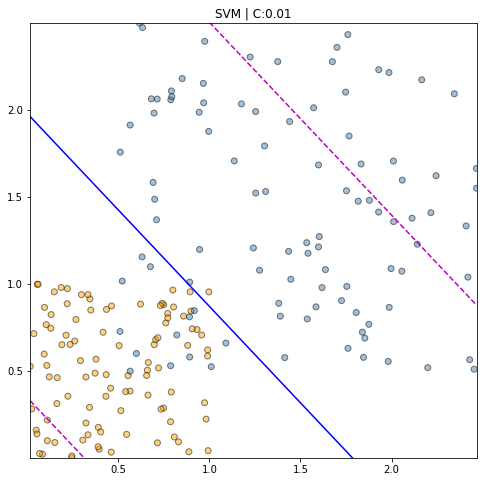

     pcost       dcost       gap    pres   dres
 0: -3.4757e+01 -4.0035e+01  1e+03  3e+01  7e-15
 1: -6.2203e+00 -3.7441e+01  8e+01  9e-01  6e-15
 2: -4.2742e+00 -1.5295e+01  1e+01  7e-16  1e-15
 3: -5.3535e+00 -7.2356e+00  2e+00  1e-15  1e-15
 4: -5.8215e+00 -6.4856e+00  7e-01  6e-16  1e-15
 5: -6.0332e+00 -6.1920e+00  2e-01  3e-16  2e-15
 6: -6.0844e+00 -6.1241e+00  4e-02  2e-16  2e-15
 7: -6.0998e+00 -6.1049e+00  5e-03  4e-16  2e-15
 8: -6.1021e+00 -6.1022e+00  6e-05  2e-16  2e-15
 9: -6.1022e+00 -6.1022e+00  6e-07  7e-16  2e-15
Optimal solution found.


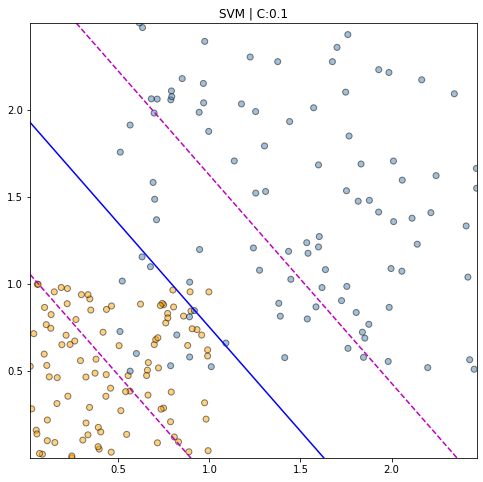

     pcost       dcost       gap    pres   dres
 0: -6.2225e+01 -4.3753e+02  2e+03  3e+00  1e-14
 1: -3.9299e+01 -2.6519e+02  4e+02  3e-01  1e-14
 2: -3.0515e+01 -7.0497e+01  5e+01  3e-02  1e-14
 3: -3.6373e+01 -5.0138e+01  2e+01  7e-03  8e-15
 4: -3.8220e+01 -4.5751e+01  8e+00  3e-03  8e-15
 5: -3.9532e+01 -4.3266e+01  4e+00  1e-03  8e-15
 6: -4.0364e+01 -4.1988e+01  2e+00  4e-04  8e-15
 7: -4.0773e+01 -4.1349e+01  6e-01  6e-05  9e-15
 8: -4.1004e+01 -4.1056e+01  5e-02  1e-15  1e-14
 9: -4.1028e+01 -4.1029e+01  6e-04  9e-16  8e-15
10: -4.1029e+01 -4.1029e+01  6e-06  2e-15  8e-15
Optimal solution found.


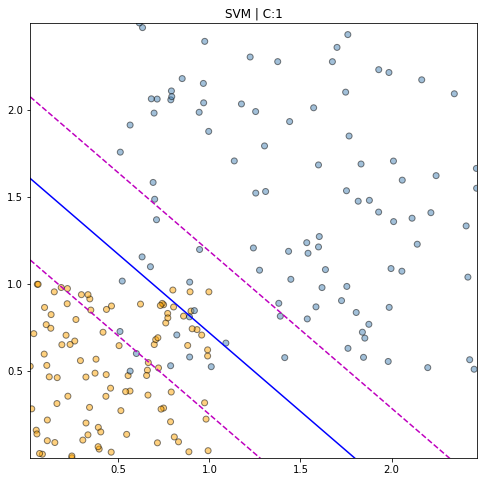

     pcost       dcost       gap    pres   dres
 0: -2.8895e+02 -1.5011e+04  4e+04  8e-01  7e-14
 1: -1.2041e+02 -4.5474e+03  6e+03  7e-02  7e-14
 2: -1.8215e+02 -1.0381e+03  1e+03  9e-03  5e-14
 3: -2.7135e+02 -5.9437e+02  3e+02  3e-03  5e-14
 4: -2.9548e+02 -5.0219e+02  2e+02  1e-03  5e-14
 5: -3.0335e+02 -4.7787e+02  2e+02  8e-04  5e-14
 6: -3.3020e+02 -4.4796e+02  1e+02  4e-04  5e-14
 7: -3.5017e+02 -3.9846e+02  5e+01  1e-04  7e-14
 8: -3.5360e+02 -3.8815e+02  3e+01  5e-05  6e-14
 9: -3.5810e+02 -3.7711e+02  2e+01  1e-05  6e-14
10: -3.6160e+02 -3.7101e+02  9e+00  5e-06  5e-14
11: -3.6531e+02 -3.6598e+02  7e-01  1e-07  7e-14
12: -3.6561e+02 -3.6561e+02  8e-03  2e-09  6e-14
13: -3.6561e+02 -3.6561e+02  8e-05  2e-11  7e-14
Optimal solution found.


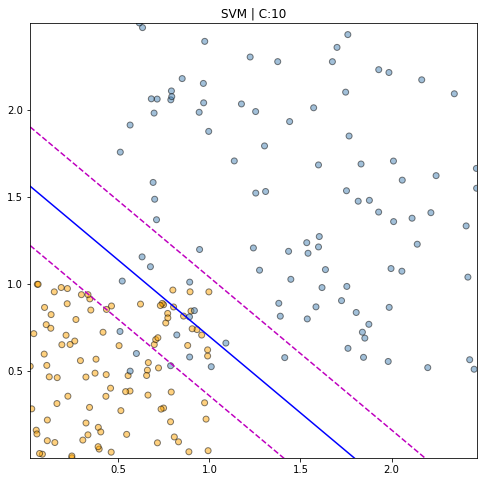

     pcost       dcost       gap    pres   dres
 0:  2.2399e+03 -1.2141e+06  3e+06  6e-01  6e-13
 1:  1.0764e+04 -2.9636e+05  4e+05  5e-02  6e-13
 2:  2.2126e+03 -5.5051e+04  6e+04  5e-03  4e-13
 3: -1.9354e+03 -1.0305e+04  8e+03  4e-04  4e-13
 4: -2.4889e+03 -8.1086e+03  6e+03  3e-04  4e-13
 5: -2.7247e+03 -5.9673e+03  3e+03  7e-05  5e-13
 6: -2.9813e+03 -5.2534e+03  2e+03  9e-06  5e-13
 7: -3.1496e+03 -5.0049e+03  2e+03  6e-06  5e-13
 8: -3.1737e+03 -4.6019e+03  1e+03  2e-06  5e-13
 9: -3.3483e+03 -4.0084e+03  7e+02  8e-07  5e-13
10: -3.3800e+03 -3.9625e+03  6e+02  5e-07  6e-13
11: -3.4594e+03 -3.8026e+03  3e+02  2e-07  5e-13
12: -3.5517e+03 -3.6435e+03  9e+01  1e-08  6e-13
13: -3.5713e+03 -3.6066e+03  4e+01  3e-09  6e-13
14: -3.5831e+03 -3.5903e+03  7e+00  5e-10  6e-13
15: -3.5862e+03 -3.5863e+03  1e-01  9e-12  6e-13
16: -3.5862e+03 -3.5862e+03  1e-03  1e-13  6e-13
Optimal solution found.


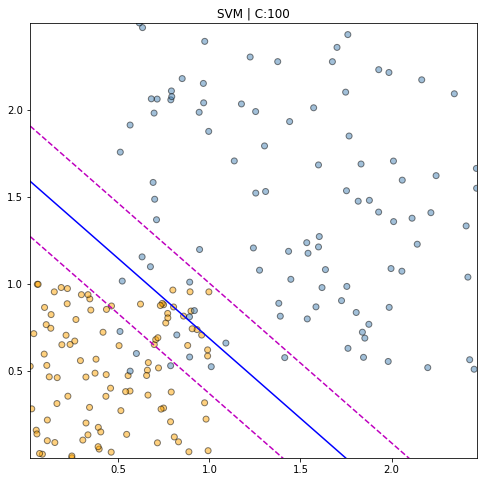

     pcost       dcost       gap    pres   dres
 0:  5.0713e+05 -1.1855e+08  3e+08  6e-01  5e-12
 1:  1.2751e+06 -2.8164e+07  4e+07  4e-02  3e-11
 2:  3.9099e+05 -5.0127e+06  6e+06  5e-03  5e-12
 3: -3.5941e+03 -5.9469e+05  6e+05  2e-04  4e-12
 4: -2.0430e+04 -1.4618e+05  1e+05  5e-05  3e-12
 5: -2.3153e+04 -9.4116e+04  7e+04  2e-05  4e-12
 6: -2.5654e+04 -7.6532e+04  5e+04  9e-06  4e-12
 7: -2.8334e+04 -5.6839e+04  3e+04  4e-06  4e-12
 8: -2.8074e+04 -5.3882e+04  3e+04  3e-06  4e-12
 9: -3.0391e+04 -5.4871e+04  2e+04  2e-06  5e-12
10: -3.1793e+04 -4.7968e+04  2e+04  1e-06  4e-12
11: -3.2225e+04 -4.4705e+04  1e+04  5e-07  6e-12
12: -3.3502e+04 -3.9462e+04  6e+03  2e-07  5e-12
13: -3.3938e+04 -3.9110e+04  5e+03  1e-07  5e-12
14: -3.4329e+04 -3.8100e+04  4e+03  5e-08  5e-12
15: -3.5080e+04 -3.6775e+04  2e+03  9e-09  6e-12
16: -3.5731e+04 -3.5854e+04  1e+02  5e-10  8e-12
17: -3.5747e+04 -3.5823e+04  8e+01  2e-10  7e-12
18: -3.5761e+04 -3.5800e+04  4e+01  4e-12  8e-12
19: -3.5776e+04 -3.57

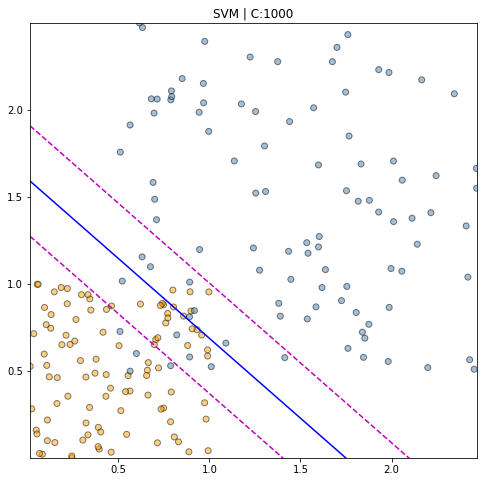

     pcost       dcost       gap    pres   dres
 0:  5.3517e+07 -1.1826e+10  3e+10  6e-01  5e-11
 1:  1.2946e+08 -2.8017e+09  4e+09  4e-02  1e-10
 2:  4.0746e+07 -4.9631e+08  6e+08  5e-03  4e-11
 3:  1.3686e+06 -5.5099e+07  6e+07  2e-04  4e-11
 4: -1.9926e+05 -2.0307e+06  2e+06  4e-06  4e-11
 5: -2.1601e+05 -1.7644e+06  2e+06  3e-06  4e-11
 6: -2.4073e+05 -9.6347e+05  7e+05  4e-07  4e-11
 7: -2.6447e+05 -8.4248e+05  6e+05  3e-07  4e-11
 8: -2.8148e+05 -5.8467e+05  3e+05  1e-07  4e-11
 9: -2.9003e+05 -5.1581e+05  2e+05  4e-08  5e-11
10: -3.0754e+05 -5.1307e+05  2e+05  2e-08  5e-11
11: -3.1386e+05 -4.4627e+05  1e+05  7e-09  4e-11
12: -3.3056e+05 -4.1628e+05  9e+04  3e-09  5e-11
13: -3.4295e+05 -3.8620e+05  4e+04  1e-09  6e-11
14: -3.5182e+05 -3.6832e+05  2e+04  3e-10  6e-11
15: -3.5635e+05 -3.5985e+05  4e+03  7e-11  6e-11
16: -3.5759e+05 -3.5791e+05  3e+02  9e-11  6e-11
17: -3.5761e+05 -3.5787e+05  3e+02  7e-11  6e-11
18: -3.5761e+05 -3.5786e+05  2e+02  1e-11  6e-11
19: -3.5766e+05 -3.57

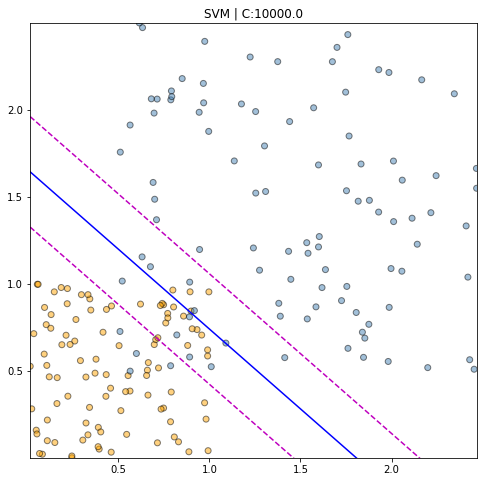

     pcost       dcost       gap    pres   dres
 0:  5.3797e+09 -1.1823e+12  3e+12  6e-01  6e-10
 1:  1.2966e+10 -2.8003e+11  4e+11  4e-02  3e-08
 2:  4.0910e+09 -4.9581e+10  6e+10  5e-03  4e-09
 3:  1.5413e+08 -5.4716e+09  6e+09  2e-04  4e-10
 4: -1.9270e+06 -1.0444e+08  1e+08  2e-06  4e-10
 5: -2.0620e+06 -1.5489e+07  1e+07  2e-07  4e-10
 6: -2.2636e+06 -1.3608e+07  1e+07  1e-07  4e-10
 7: -2.6211e+06 -7.3651e+06  5e+06  5e-08  4e-10
 8: -2.4456e+06 -6.3363e+06  4e+06  3e-08  4e-10
 9: -2.7543e+06 -6.3881e+06  4e+06  2e-08  4e-10
10: -2.9162e+06 -5.3174e+06  2e+06  4e-09  5e-10
11: -3.1337e+06 -4.8584e+06  2e+06  2e-09  5e-10
12: -3.1717e+06 -4.5640e+06  1e+06  9e-10  6e-10
13: -3.3547e+06 -3.9489e+06  6e+05  4e-10  5e-10
14: -3.3896e+06 -3.9083e+06  5e+05  7e-10  5e-10
15: -3.4384e+06 -3.7978e+06  4e+05  1e-10  6e-10
16: -3.4822e+06 -3.7304e+06  2e+05  1e-10  5e-10
17: -3.5304e+06 -3.6378e+06  1e+05  3e-11  6e-10
18: -3.5638e+06 -3.5922e+06  3e+04  4e-11  7e-10
19: -3.5749e+06 -3.57

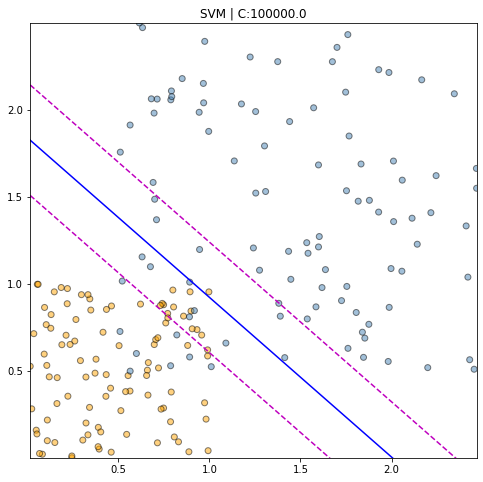

In [10]:
def test_SVMs(list_C):
  for C in list_C:
    classifier = SVM(C=C)
    alphas = classifier.fit(X,y)
    ypred = classifier.predict(X)
    plot_margin(X, classifier, title='SVM | C:{}'.format(C))

test_SVMs([0.001,0.01, 0.1, 1,10,100,1000,1e4,1e5])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

     pcost       dcost       gap    pres   dres
 0: -2.1719e+02 -1.1502e+04  3e+04  8e-01  3e-14
 1: -7.5249e+01 -3.3138e+03  4e+03  6e-02  2e-14
 2: -1.3953e+02 -7.9269e+02  7e+02  8e-03  2e-14
 3: -2.1894e+02 -4.5922e+02  3e+02  3e-03  2e-14
 4: -2.4689e+02 -3.8098e+02  1e+02  1e-03  2e-14
 5: -2.6537e+02 -3.4226e+02  8e+01  4e-04  3e-14
 6: -2.7682e+02 -3.2219e+02  5e+01  2e-04  2e-14
 7: -2.8066e+02 -3.0545e+02  2e+01  3e-05  2e-14
 8: -2.8414e+02 -3.0140e+02  2e+01  7e-06  2e-14
 9: -2.8960e+02 -2.9295e+02  3e+00  1e-06  3e-14
10: -2.9094e+02 -2.9099e+02  5e-02  2e-08  3e-14
11: -2.9096e+02 -2.9096e+02  5e-04  2e-10  3e-14
12: -2.9096e+02 -2.9096e+02  5e-06  2e-12  3e-14
Optimal solution found.


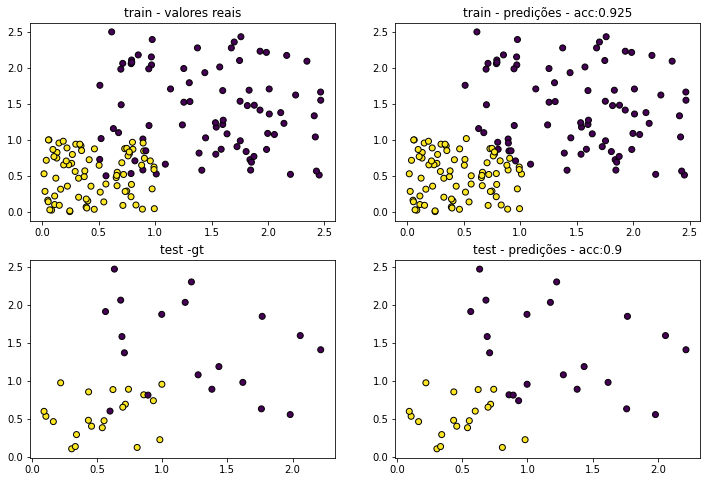

In [12]:
def train_svm_and_plot(C):

  classifier = SVM(C=C)
  alphas = classifier.fit(X_train,y_train)

  ypred_train = classifier.predict(X_train)
  ypred_test = classifier.predict(X_test)

  fig, axis = plt.subplots(2,2, figsize=(12,8))

  axis[0,0].scatter(X_train[:, 0],
              X_train[:, 1],
              c=y_train.astype(int),
              edgecolors="black")
  axis[0,0].set_title('train - valores reais')

  axis[0,1].scatter(X_train[:, 0],
              X_train[:, 1],
              c=ypred_train.astype(int),
              edgecolors="black")

  axis[0,1].set_title('train - predições - acc:{}'.format(np.mean(y_train.flatten()==ypred_train.flatten())))


  axis[1,0].scatter(X_test[:, 0],
              X_test[:, 1],
              c=y_test.astype(int),
              edgecolors="black")

  axis[1,0].set_title('test -gt')


  axis[1,1].scatter(X_test[:, 0],
              X_test[:, 1],
              c=ypred_test.astype(int),
              edgecolors="black")
  axis[1,1].set_title('test - predições - acc:{}'.format(np.mean(y_test.flatten()==ypred_test.flatten())))


train_svm_and_plot(C=10)

# SVM soft margin e kernel + aplicação em distribuições aleatórias 

---



In [13]:
class SVM_kernel():

  def __init__(self, C, kernel_type='poly', kernel_params=None, solver ="quadprog", tol=1e-5, verbose=False ):
    assert C>0, 'C precisa ser uma constante positiva'
    self.C=float(C)
    self.kernel_type = kernel_type
    self.kernel_params = kernel_params
    self.solver = solver
    self.tol = tol
    self.verbose=verbose
    cvxopt.solvers.options['show_progress'] = verbose

  def fit(self,X,y):

    # Check https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

    class_labels = np.unique(y)
    assert len(class_labels)==2, "y precisa ser binário"
    # assert (isinstance(X,  (np.ndarray, np.generic))) & (isinstance(y, (np.ndarray, np.generic))), "X e y devem ser do tipo pandas numpy arrays"

    X = np.array(X)
    y = np.array(y)
    self.m = X.shape[0]

    self.X=X
    self.y=y
    
    # Equação principal
    P = self.calculate_kernel()

    q = -np.ones((self.m,1)).reshape(-1,1)

    # Inegualidades
    G_lb = -np.eye(self.m)
    h_lb = np.zeros(self.m).reshape(-1,1)

    G_ub = np.eye(self.m)
    h_ub = self.C*np.ones(self.m).reshape(-1,1)

    G = np.vstack((G_lb,G_ub))
    h = np.vstack((h_lb,h_ub))

    # Igualdade
    A = y.reshape(1,-1).astype(float)
    b = 0.0

    P       = cvxopt.matrix(P)
    q       = cvxopt.matrix(q)
    G       = cvxopt.matrix(G)
    h       = cvxopt.matrix(h)
    A       = cvxopt.matrix(A)
    b       = cvxopt.matrix(b)

    solved  = cvxopt.solvers.qp(P, q, G, h, A, b, show_progress=False) ;
    alpha = solved['x']

    alpha = np.array(alpha)
    sv = (alpha>1e-5).flatten()
    self.alpha = alpha
    self.sv = sv

    # w = np.dot((alpha[sv]*y[sv]).reshape(1,-1), X[sv])[0] # w precisar ter dimensao 1 x ne
    # wx = np.dot(X[sv], w)
    # b = np.mean(y[sv] - wx)
    # self.w = w
    # self.b = b



  def check_param(self, param):
    assert param in self.kernel_params.keys(), 'se o kernel é {} é necessário ter declarado o parametro {}'.format(self.kernel_type,param)

  def calculate_kernel(self):

    assert isinstance(self.kernel_params, dict), 'kernel_params precisa ser um dicionario'
    assert self.kernel_type in ['poly', 'rbf'], 'kernel_type precisa ser poly ou rbf'

    K = np.zeros((self.m, self.m))
    H = np.zeros((self.m, self.m))

    if self.kernel_type=='poly':
      self.check_param('d')
      d = self.kernel_params['d']

      for i in range(0, self.m):
        for j in range(0, self.m):
          K[i,j] = (self.X[i,:]@self.X[j,:]+1)**d
          H[i,j] = K[i,j]*self.y[i,0]*self.y[j,0]

      return H

    elif self.kernel_type=='rbf':
      self.check_param('sigma')
      sigma = self.kernel_params['sigma']

      for i in range(0, self.m):
        for j in range(0, self.m):
          K[i,j] = np.exp(-np.linalg.norm(self.X[i,:] - self.X[j,:])**2/(2*sigma**2))
          H[i,j] = K[i,j]*self.y[i,0]*self.y[j,0]
          
      return H
      

  def predict(self, X_tst):

    X_tst = np.array(X_tst)
    m_test = X_tst.shape[0]

    alphasv = self.alpha[self.sv]
    Xsv = self.X[self.sv,:]
    ysv = self.y[self.sv,:]
    m_sv = Xsv.shape[0]

    K = np.zeros((m_sv, m_test))

    for i in range(0, m_sv):
      for j in range(0, m_test):
        if self.kernel_type=='poly':
          K[i,j] = (Xsv[i,:] @ X_tst[j,:]+1)**self.kernel_params['d']

        elif self.kernel_type=='rbf':
          # print(Xsv[i,:])
          # print(X_tst[j,:])
          K[i,j] = np.exp(-np.linalg.norm(Xsv[i,:].flatten() - X_tst[j,:].flatten())**2/(2*self.kernel_params['sigma']**2))
          


    yhat = np.sign((alphasv * ysv).T@K)

    return yhat

     pcost       dcost       gap    pres   dres
 0:  4.9015e+02 -4.8633e+05  8e+05  2e-01  5e-11
 1: -1.1842e+03 -9.2466e+04  1e+05  2e-02  5e-11
 2: -1.4881e+03 -4.3445e+04  5e+04  7e-03  3e-11
 3: -1.1927e+03 -1.8185e+04  2e+04  2e-03  2e-11
 4: -1.4682e+03 -7.8707e+03  7e+03  7e-04  3e-11
 5: -1.9095e+03 -3.4642e+03  2e+03  1e-04  2e-11
 6: -2.1805e+03 -2.8562e+03  7e+02  2e-05  3e-11
 7: -2.2878e+03 -2.5224e+03  2e+02  2e-06  3e-11
 8: -2.3276e+03 -2.4431e+03  1e+02  6e-07  3e-11
 9: -2.3456e+03 -2.4193e+03  7e+01  1e-07  3e-11
10: -2.3634e+03 -2.3893e+03  3e+01  1e-08  3e-11
11: -2.3708e+03 -2.3789e+03  8e+00  3e-09  2e-11
12: -2.3741e+03 -2.3744e+03  3e-01  3e-11  3e-11
13: -2.3742e+03 -2.3742e+03  3e-03  3e-13  3e-11
14: -2.3742e+03 -2.3742e+03  3e-05  5e-13  4e-11
Optimal solution found.


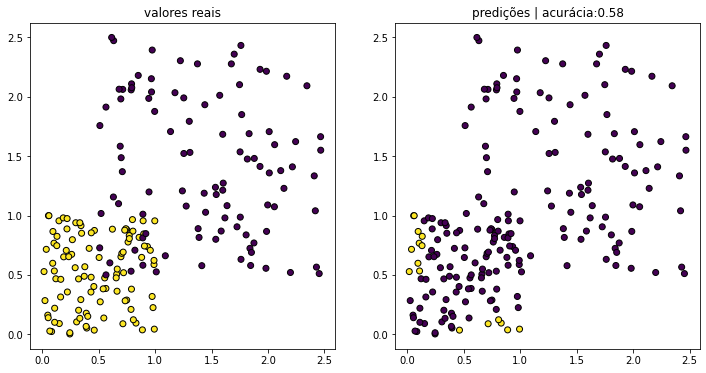

In [14]:
C=100

model = SVM_kernel(C=C, kernel_type='poly', kernel_params={'d':4}, verbose=True)

pipeline_SVM(model)

sigma:0.001 C:1


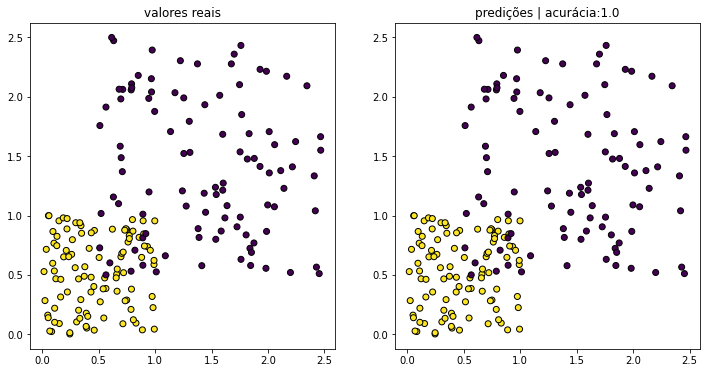

sigma:0.001 C:10


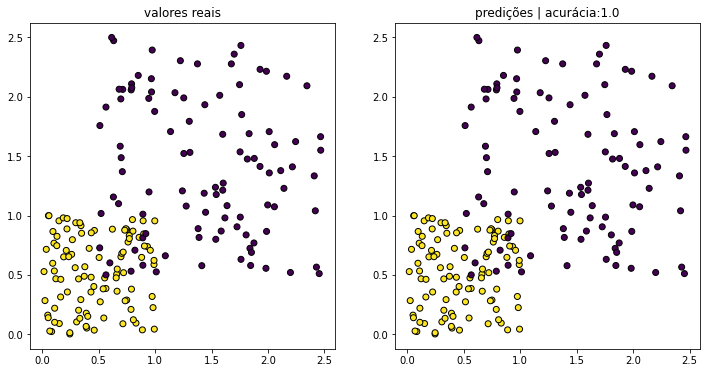

sigma:0.001 C:100


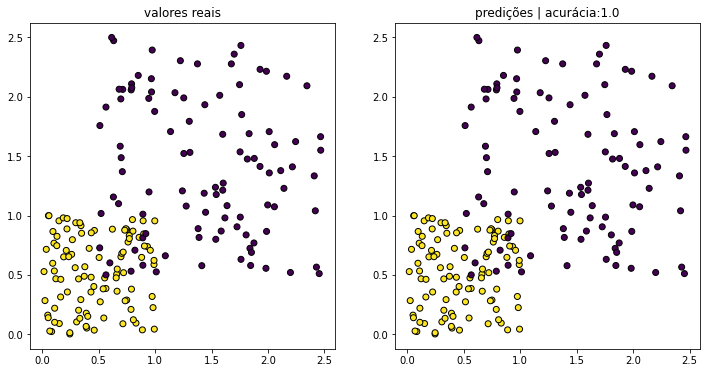

sigma:0.001 C:1000


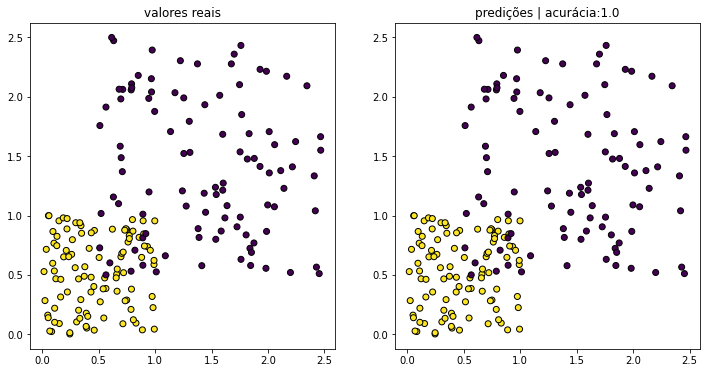

sigma:0.001 C:10000


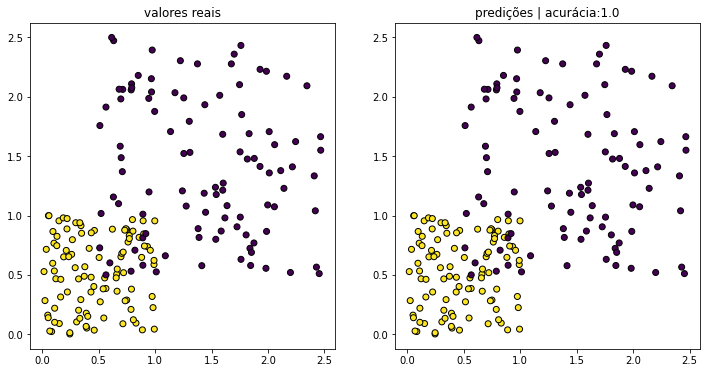

sigma:0.001 C:100000


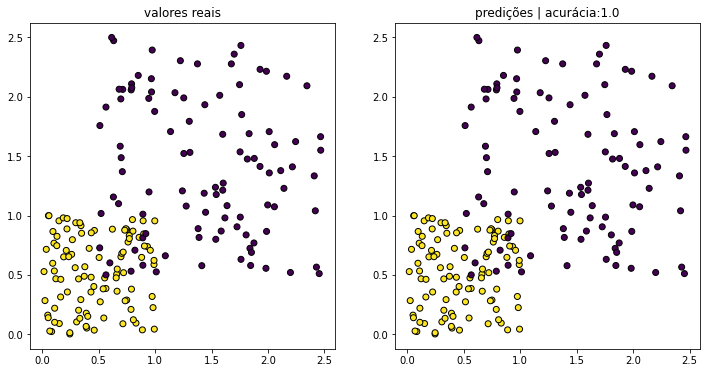

sigma:0.01 C:1


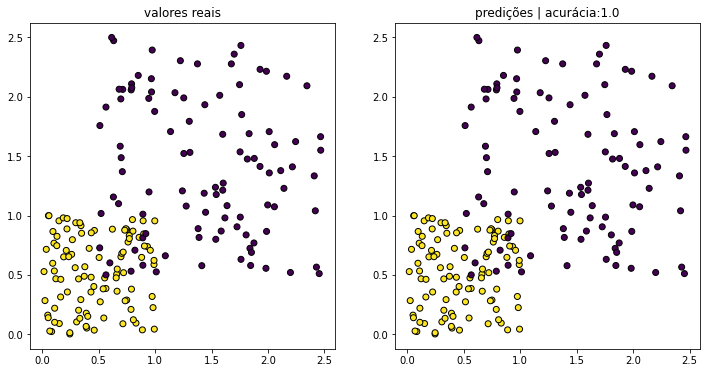

sigma:0.01 C:10


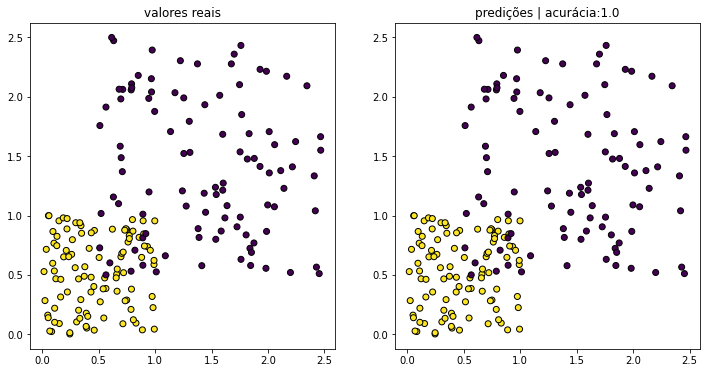

sigma:0.01 C:100


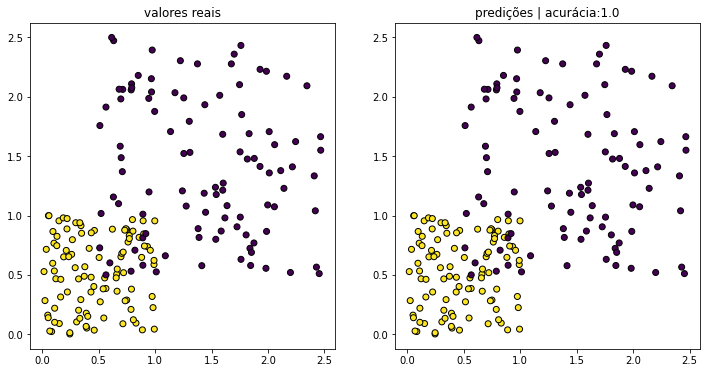

sigma:0.01 C:1000


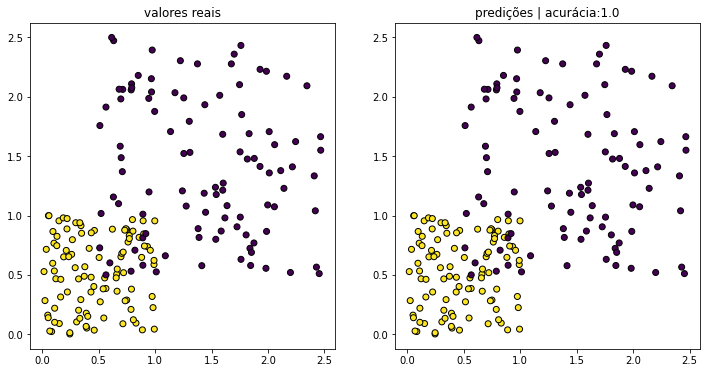

sigma:0.01 C:10000


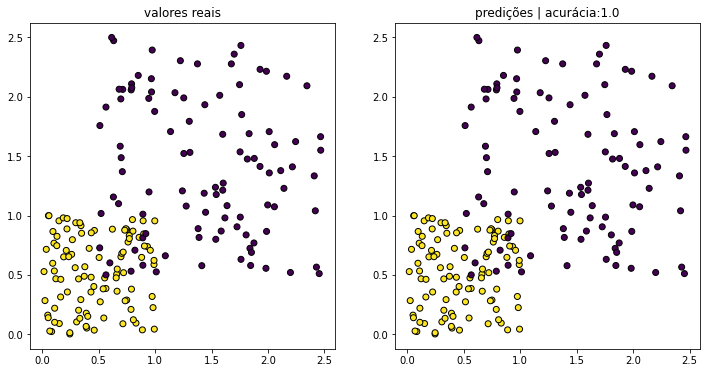

sigma:0.01 C:100000


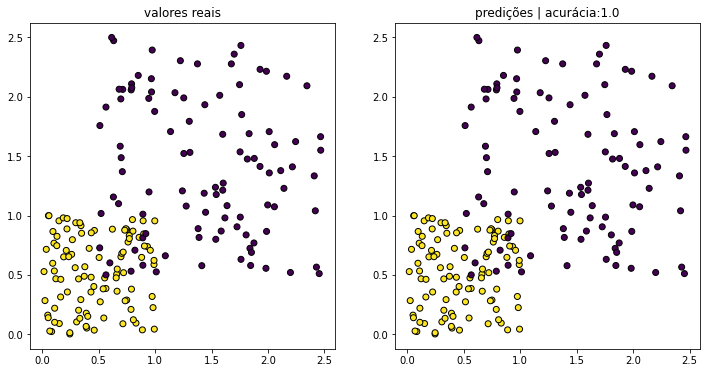

sigma:0.1 C:1


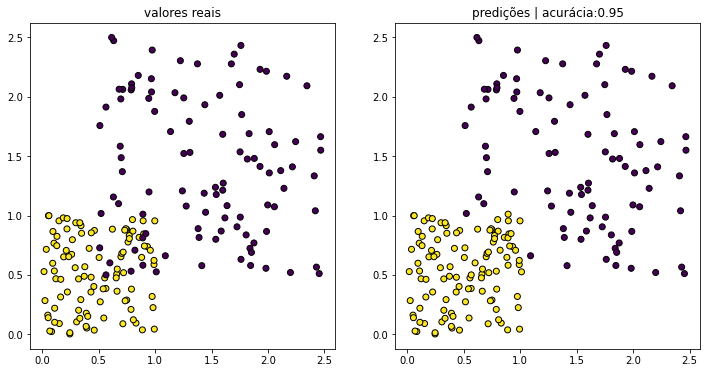

sigma:0.1 C:10


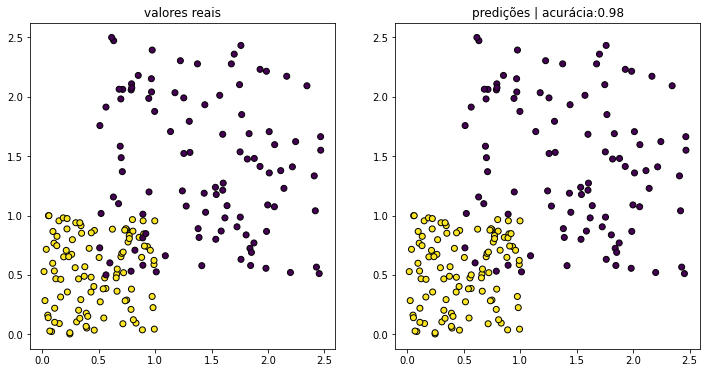

sigma:0.1 C:100


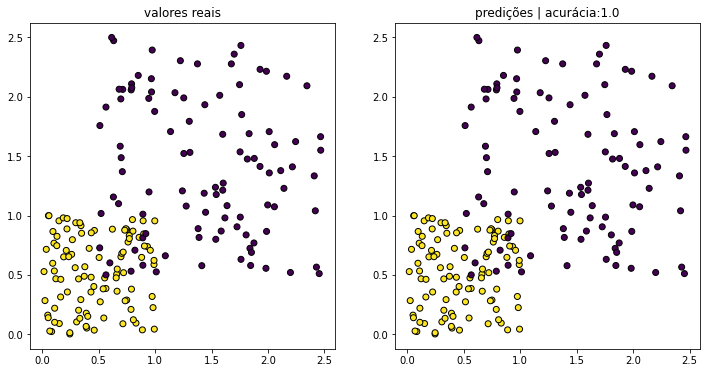

sigma:0.1 C:1000


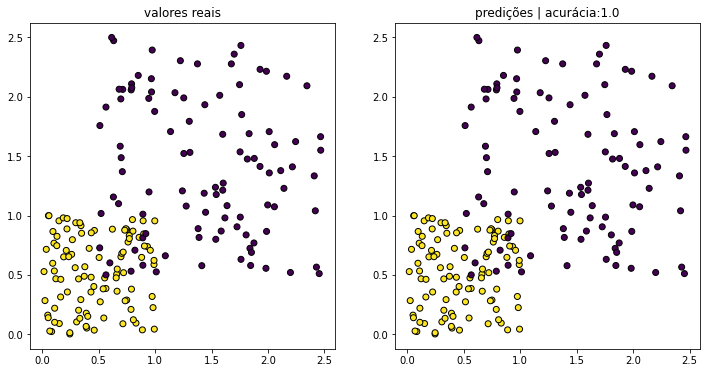

sigma:0.1 C:10000


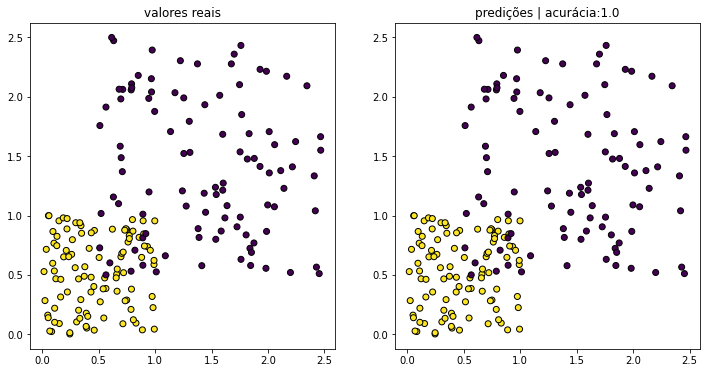

sigma:0.1 C:100000


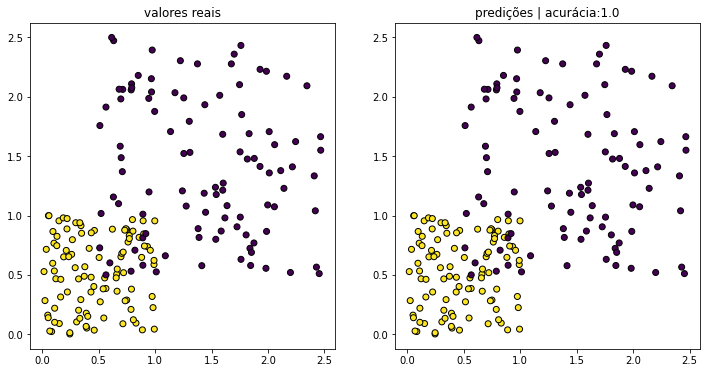

sigma:1 C:1


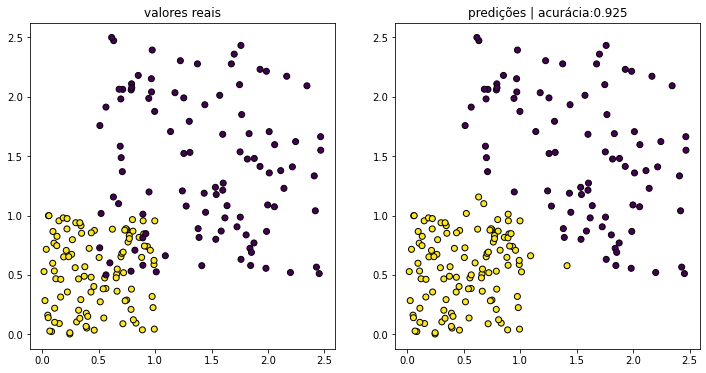

sigma:1 C:10


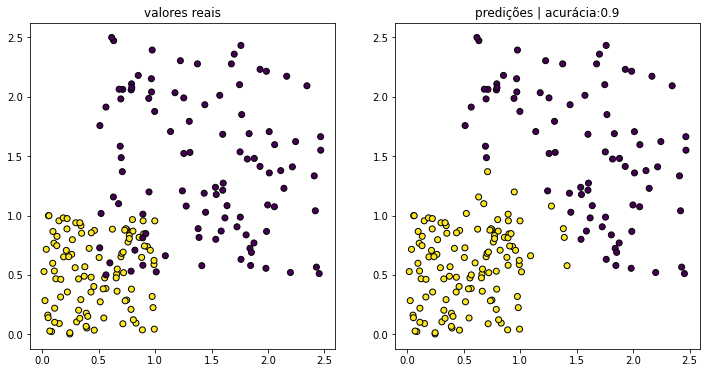

sigma:1 C:100


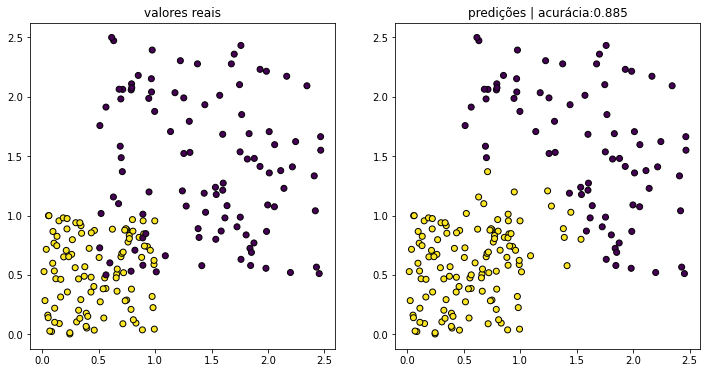

sigma:1 C:1000


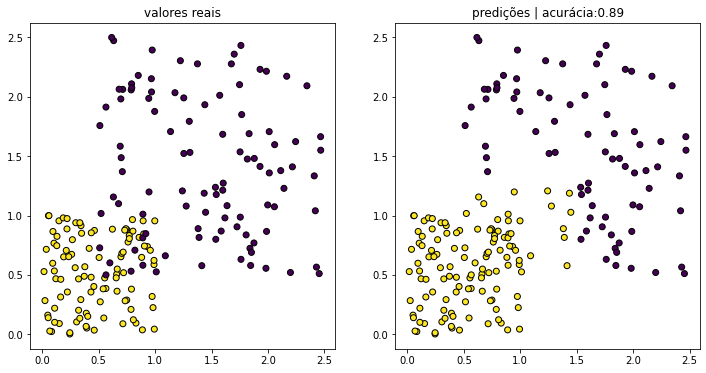

sigma:1 C:10000


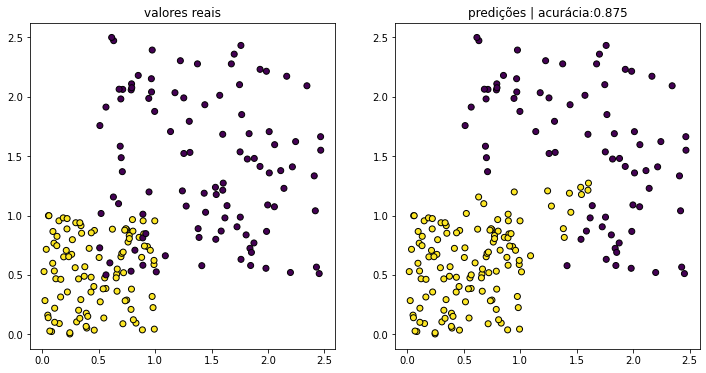

sigma:1 C:100000


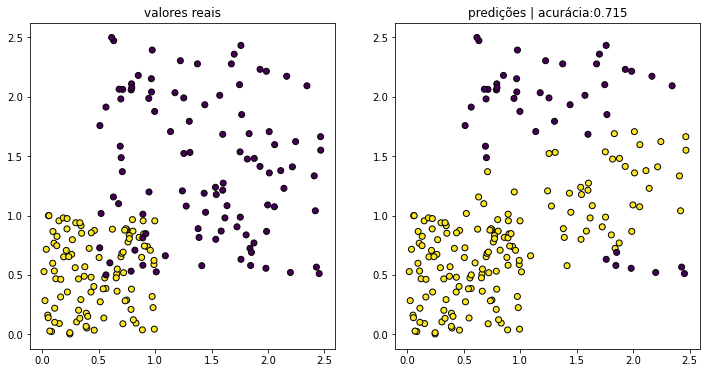

sigma:10 C:1


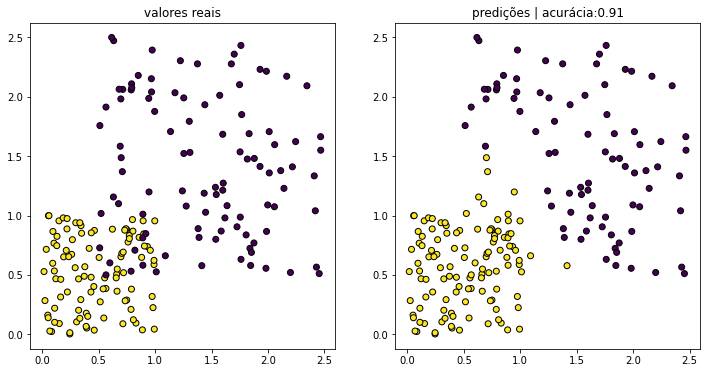

sigma:10 C:10


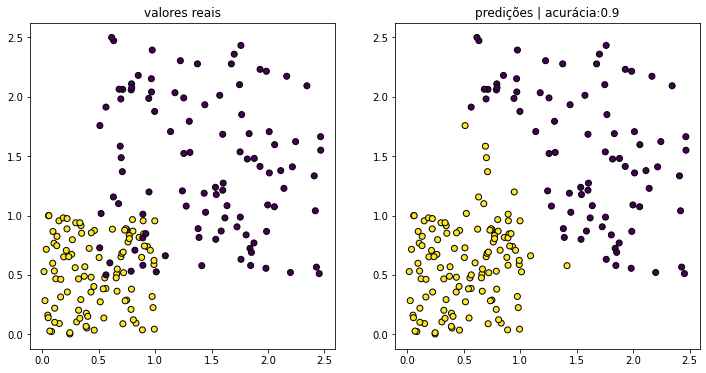

sigma:10 C:100


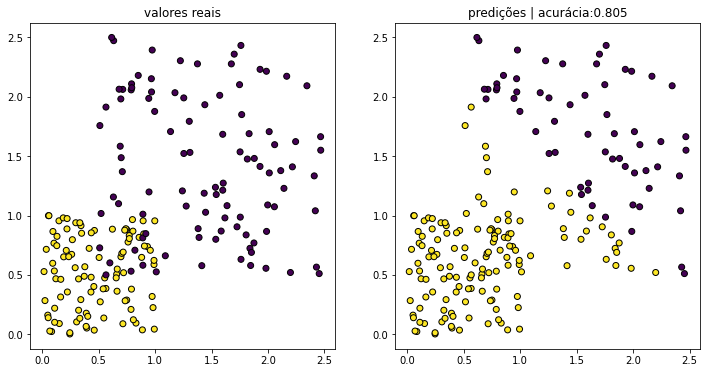

sigma:10 C:1000


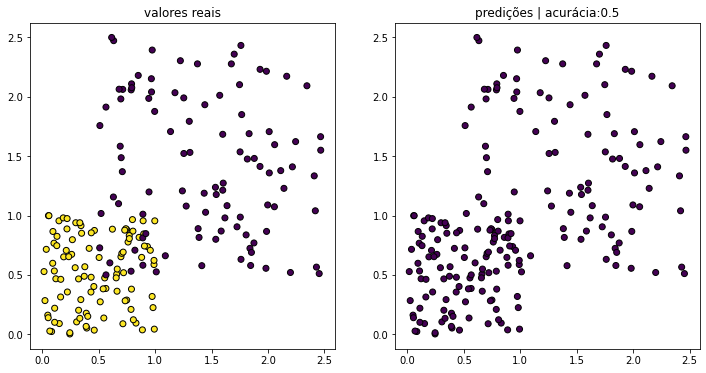

sigma:10 C:10000


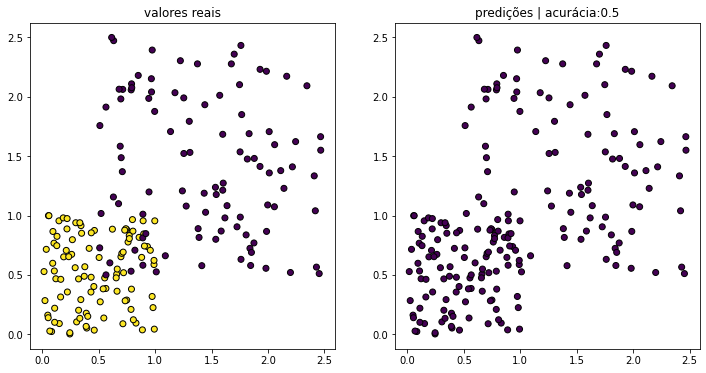

sigma:10 C:100000


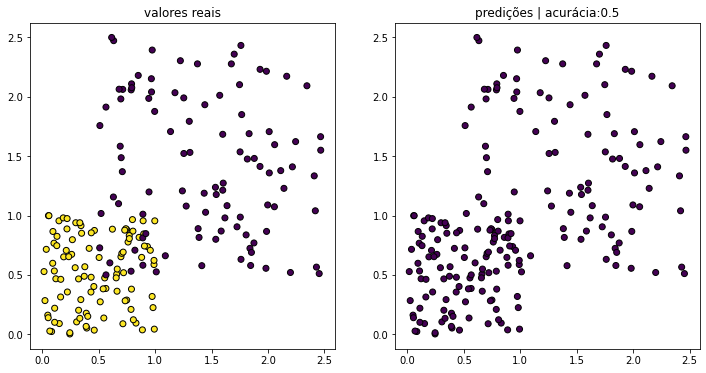

sigma:100 C:1


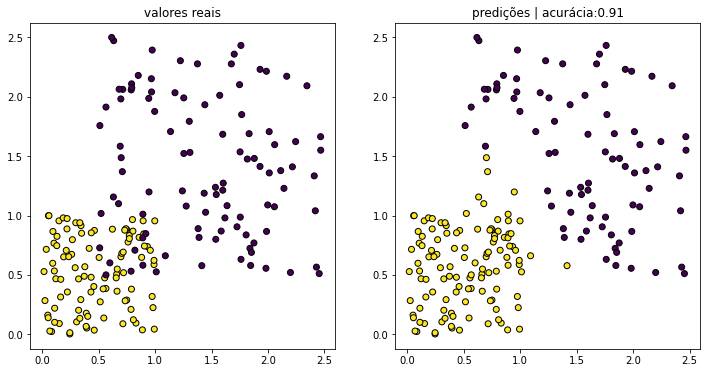

sigma:100 C:10


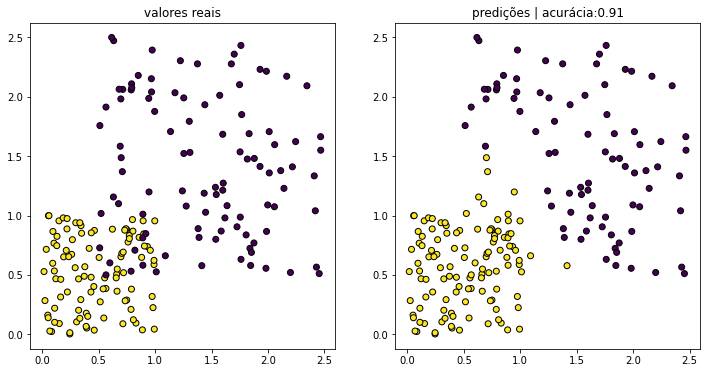

sigma:100 C:100


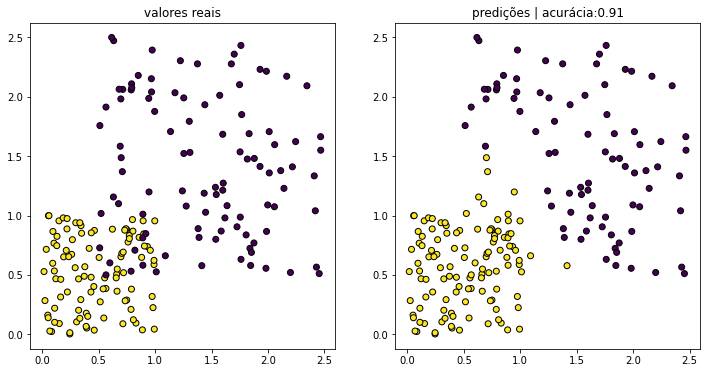

sigma:100 C:1000


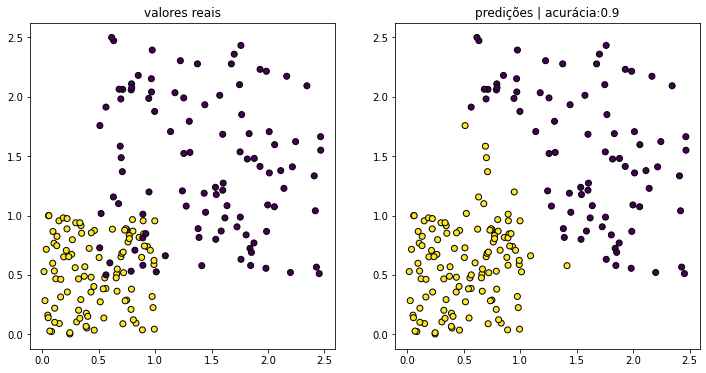

sigma:100 C:10000


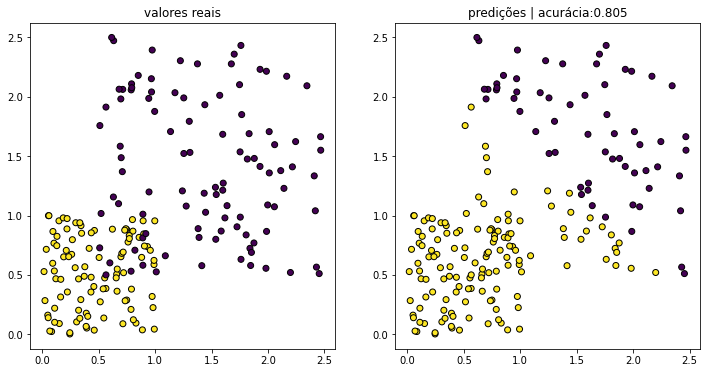

sigma:100 C:100000


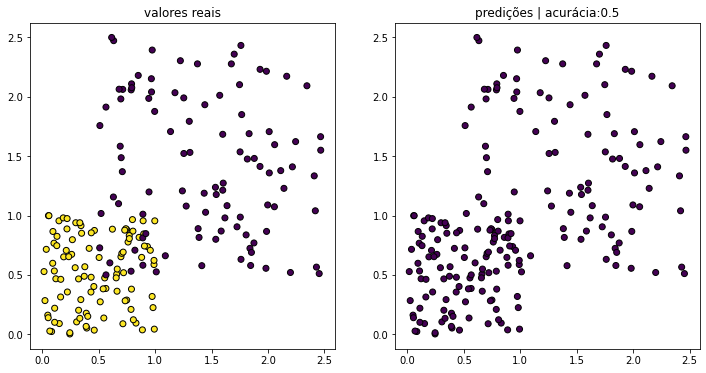

In [15]:
for sigma in [.001,.01, .1, 1, 10, 100]:
  for C in [1,10,100,1000,10000,100000]:
    print('sigma:{} C:{}'.format(sigma,C))
    model = SVM_kernel(C=C, kernel_type='rbf', kernel_params={'sigma':sigma})
    pipeline_SVM(model)
    plt.show()

# SVM soft margin e kernel + aplicação em cancer dataset


In [16]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns= cancer.feature_names)
y = pd.DataFrame(cancer.target, columns= ['target'])
y['target'] = y['target'].apply(lambda x:2*x-1)
m = X.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = (X_test - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))
X_train = (X_train - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))

In [17]:
print('X:',X.shape)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X: (569, 30)
X_train: (455, 30)
y_train: (455, 1)
X_test: (114, 30)
y_test: (114, 1)


In [18]:
# from sklearn.svm import LinearSVC

# classifier = LinearSVC(random_state=0, tol=1e-5)
# classifier.fit(X_train,y_train)

# ypred_train = classifier.predict(X_train)
# ypred_test = classifier.predict(X_test)
# print('acuracia treino:{} acuracia teste:{}'.format(np.mean(ypred_train.flatten()==y_train.values.flatten()), np.mean(ypred_test.flatten()==y_test.values.flatten())))

In [19]:
# from sklearn.svm import SVC

# classifier = SVC(gamma='auto')
# classifier.fit(X_train,y_train)

# ypred_train = classifier.predict(X_train)
# ypred_test = classifier.predict(X_test)

# print('acuracia treino:{} acuracia teste:{}'.format(np.mean(ypred_train.flatten()==y_train.values.flatten()), np.mean(ypred_test.flatten()==y_test.values.flatten())))

In [20]:
gridsearch = {}
it = 0

for C in [1,10,100,1000,10000,100000]:
  classifier = SVM(C=C, verbose=False)
  classifier.fit(X_train,y_train)

  ypred_train = classifier.predict(X_train)
  ypred_test = classifier.predict(X_test)

  gridsearch[it] = (C, np.mean(ypred_train.flatten()==y_train.values.flatten()),np.mean(ypred_test.flatten()==y_test.values.flatten()))
  
  print(gridsearch[it])
  
  it+=1

(1, 0.9824175824175824, 0.9736842105263158)
(10, 0.9846153846153847, 0.9736842105263158)
(100, 0.989010989010989, 0.956140350877193)
(1000, 0.9956043956043956, 0.9649122807017544)
(10000, 0.9978021978021978, 0.9035087719298246)
(100000, 1.0, 0.9385964912280702)


In [21]:
gridsearch = {}
it = 0

for sigma in [.001,.01, .1, 1, 10, 100]:
  for C in [1,100,1000,10000,100000]:
    classifier = SVM_kernel(C=C, kernel_type='rbf', kernel_params={'sigma':sigma}, verbose=False)
    classifier.fit(X_train,y_train)

    ypred_train = classifier.predict(X_train)
    ypred_test = classifier.predict(X_test)

    gridsearch[it] = (sigma, C, np.mean(ypred_train.flatten()==y_train.values.flatten()),np.mean(ypred_test.flatten()==y_test.values.flatten()))
  
    print(gridsearch[it])
    
    it+=1



(0.001, 1, 1.0, 0.0)
(0.001, 100, 1.0, 0.0)
(0.001, 1000, 1.0, 0.0)
(0.001, 10000, 1.0, 0.0)
(0.001, 100000, 1.0, 0.0)
(0.01, 1, 1.0, 0.6666666666666666)
(0.01, 100, 1.0, 0.6666666666666666)
(0.01, 1000, 1.0, 0.6666666666666666)
(0.01, 10000, 1.0, 0.6666666666666666)
(0.01, 100000, 1.0, 0.6666666666666666)
(0.1, 1, 1.0, 0.956140350877193)
(0.1, 100, 1.0, 0.956140350877193)
(0.1, 1000, 1.0, 0.956140350877193)
(0.1, 10000, 1.0, 0.956140350877193)
(0.1, 100000, 1.0, 0.956140350877193)
(1, 1, 0.967032967032967, 0.9736842105263158)
(1, 100, 0.9912087912087912, 0.9824561403508771)
(1, 1000, 1.0, 0.956140350877193)
(1, 10000, 1.0, 0.956140350877193)
(1, 100000, 1.0, 0.956140350877193)
(10, 1, 0.9142857142857143, 0.9035087719298246)
(10, 100, 0.8901098901098901, 0.9122807017543859)
(10, 1000, 0.6923076923076923, 0.7105263157894737)
(10, 10000, 0.6307692307692307, 0.6228070175438597)
(10, 100000, 0.6307692307692307, 0.6228070175438597)
(100, 1, 0.8879120879120879, 0.868421052631579)
(100, 100, 

In [ ]:
results_df = pd.DataFrame(gridsearch).T
results_df.columns = ['sigma', 'C', 'acuracia_tr','acuracia_tst']
results_df